# Example of Instrument Control from Notebook

Lets say we want to use a notebook to do some data processing. You might think you'd then need to collect all your data, type it into a spreadhsheet, and the somehow import it into the notebook in order to use it. Not so!

## Setup and Libraries

We can use Python libraries to directly interface with test equipment and collect data. We'll use some open libraries like Py-VISA and Python VXI-11 to talk to test equipment over the network.

First we'll begin by importing the libraries required to talk to the test equipment. In my development environment at home, I have a couple of things connected to the network that we'll try talking to. We'll keep track of network information for the test equipment in the lab on the Confluence wiki. 

We'll also import some fairly common libraries to work with and view the data. We'll need Numpy (the Python matrix math library) and Matplotlib (the plotting library). As before, we use the `as` keyword to abbreviate the library names with their conventional abbreviations so we don't need to type the whole thing.

## Setting Up Interfaces

We'll first try to talk to an old Keysight VNA, an E5062A. Its a two port, 3 GHz model conected by ethernet. We construct an instrument 'object' called E5062A by calling the vxi11 library and inputting the IP address of the instrument and it's internal VISA/SICL name. Finding this information on the actual instrument itself is the hardest part of this.

We can test if we've correctly identified and connected to the instrument by sending the VISA command `*IDN?` which is one of the very few universal commands for for test equipment. If it responds, the code chunk will print out the response in the output block with some text description of the Manufacturer, Model, and Firmware version. If we get an error, there is something wrong with our network setup.



In [5]:
# Import the VXI Library
import vxi11

# Import other stuff
import matplotlib.pyplot as plt 
import numpy as np

# Define the instrument we'll be connecting to. If we talk to multiple things, we can define multiple instruments
E5062A =  vxi11.Instrument("10.1.10.177", "hpib9,17")

# Send the ID query to verify communications. Print result. This is the hardest part.
print(E5062A.ask("*IDN?"))



Agilent Technologies,E5062A,MY44100797,A.01.00


## Lets Get Some Data

Rather than screw around with a bunch of tedious settings and setup, lets just get straight to the point - lets grab the current trace data from the VNA. We're going to leave all the settings as they are on the physical VNA and pull down the Formatted Data (trace currently on the screen in the format on screen). In the example data here, the VNA is set up with a 2.5 GHz path antenna connected to Port 1 and Port 2 is terminated. (Not that it matters but it's a 2.4 GHz antenna that is detuned becuause it's ouside of its FRP housing which loads the resonant frequency down about 50 MHz)

We use the VXI-11 library command `ask` on the instruments object using a dot. The ask command sends the instruction and waits for a response. There are other commands that allow you to send-only or read-only. 

We take the trace data itself and copy it into a variable we call *data*. We also have to ask for the frequency points that the data corrisponds to.

Where the heck did we find the commands? We just did a web search for the the model number of the instrument and "programming manual" and it came up as the first result, on the Keysight website.

In [2]:
# Request the Formatted Data (trace currently on the screen in the format on screen)
data = E5062A.ask(":CALC1:DATA:FDAT?")

# Request the Frequency Data 
freq = E5062A.ask(":SENS1:FREQ:DATA?")

## Inspecting the Data

Now that we've got our data, let's print it out and see how it's formatted.

In [3]:
# Print the label, then print an extra line break, the '\n' "newline", to make it look a bit neater.
print("Frequency trace:", '\n')
# Print the frequency data itself.
print(freq, '\n')

print("Data trace:", '\n')
print(data, '\n')

Frequency trace: 

+3.00000000000E+005,+1.52985000000E+007,+3.02970000000E+007,+4.52955000000E+007,+6.02940000000E+007,+7.52925000000E+007,+9.02910000000E+007,+1.05289500000E+008,+1.20288000000E+008,+1.35286500000E+008,+1.50285000000E+008,+1.65283500000E+008,+1.80282000000E+008,+1.95280500000E+008,+2.10279000000E+008,+2.25277500000E+008,+2.40276000000E+008,+2.55274500000E+008,+2.70273000000E+008,+2.85271500000E+008,+3.00270000000E+008,+3.15268500000E+008,+3.30267000000E+008,+3.45265500000E+008,+3.60264000000E+008,+3.75262500000E+008,+3.90261000000E+008,+4.05259500000E+008,+4.20258000000E+008,+4.35256500000E+008,+4.50255000000E+008,+4.65253500000E+008,+4.80252000000E+008,+4.95250500000E+008,+5.10249000000E+008,+5.25247500000E+008,+5.40246000000E+008,+5.55244500000E+008,+5.70243000000E+008,+5.85241500000E+008,+6.00240000000E+008,+6.15238500000E+008,+6.30237000000E+008,+6.45235500000E+008,+6.60234000000E+008,+6.75232500000E+008,+6.90231000000E+008,+7.05229500000E+008,+7.20228000000E+008,+

## What we got from the VNA

This looks absurdly complicated but I promise it's not. 

Let's start with the frequency data which is just slightly easier to deal with. What we have here is a single, very long piece of text (a string) which represents a bunch of numbers seperated by commas. You need to keep in mind that to the computer, there is a difference between a 'text' number and a 'value' number. To do math on it and plot it, it needs to be a value and not text (a string).

We need to turn the big string into an array (a collection) of individual value numbers (versus the ASCII text representation of numbers).

First, we take our frequency string and then we split that into a a collection of individual strings every time there is a comma in the big string. We do this by adding a command on the end called split. 

 `.split('.')`

Incidentally, you can use the split command for any seperator of the values, not just the comma. You would just replace the comma in the command with the separating character. 

Our next problem is that the output of the split command is technically called a "list". A list isn't good for dealing with numbers. We want to convert it to a proper array so we can do math (i.e. matrix math) on it. So, we put that collection of individual strings inside of the np.asarray() function to convert the collection of strings into a proper array. Then, finally, we tack an .astype(float) onto the end to convert each cell in the array from a string (text) to a real floating point number. 

You could do all of these commands one at a time, assiging a new variable name each time. But we're going to skip the steps and do it all in one line. 



In [11]:
freq_array = np.asarray(freq.split(',')).astype(float)
print("Frequency trace:", '\n')
# Print the frequency data itself.
print(freq, '\n')

print("Data trace:", '\n')
print(data, '\n')print("Frequency trace:", '\n')
# Print the frequency data itself.
print(freq, '\n')

print("Data trace:", '\n')
print(data, '\n')
print(freq_array)

## Now the Data

The data array has one added complication - there are placholders for the imaginary part of the number because some formats of data display require complex numbers. In our sample case, we're looking at S11 Log-Mag so there is no imaginary component. To use this data, we need to get rid of the empty spots that hold the imaginary component of some formats of results.

 We can throw away every other element of the array by using a fancy method of indexing into the array of data called *slicing*. An array is a collection of data addresses. You access the contents of the address with an index. Lets make an example array called *my_array*

 `my_array = [42 37 28 10]`

 You would index into the array with square brackets. `my_array[0] = 42`. `my_array[2] = 28`, etc. You can use colons to give a range of values. `my_array[0:2] = [42 37 28]`. This is called a *slice* of *my_array*. You can add a third colon to the slicing index to specify how many indecies you go by when moving through the data. If you don't specify, the default is one.

So, we slice by adding `[0::2]`  to get the first number (index starts at 0) we go all the way to the end (the default if you don't specify an ending index after the first colon) and we get every second element. 

Again, we start at the first element (index 0), we go to the end, and we increment the index by 2 every time we grab an element of the array. If you wanted to get every third value, we would use `[0::3]`. If we wanted every 4th value starting with the second element in the array, we would use `[1::4]`



In [7]:
data_array = np.asarray(data.split(',')).astype(float)[0::2]

print(data_array)

## Plotting

Lets plot this using Matplotlib and see if it looks correct. The test data is a 2.4 GHz patch antenna. S11 should be very low at its resonant frequency, Its a bit off in frequency because its being measured outside of its case.

The most basic form of the plot command is to use the plot function of the Matplotlib library we imported earlier and abbreviated as `plt`. Inside the function (inside the parentheses) we just specify the X values, comma, and the Y values. 

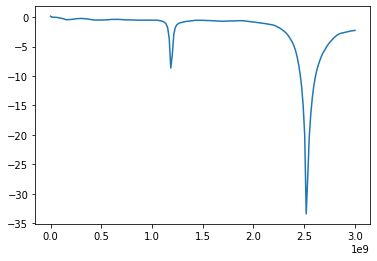

In [8]:
plt.plot(freq_array,data_array)

## Prettier, please. 

So we have a plot. Its a little small, hard to read, and not really that good looking. We can add some commands to adjust the formatting. We're not going to get into the details now of exactly how to use all these. To be honest, I never memorize these. I just copy them and paste them from whatever my last project was and then adjust if nessisary. These are purey optional formatting.

After we set the format, we'll just run our plot command again.


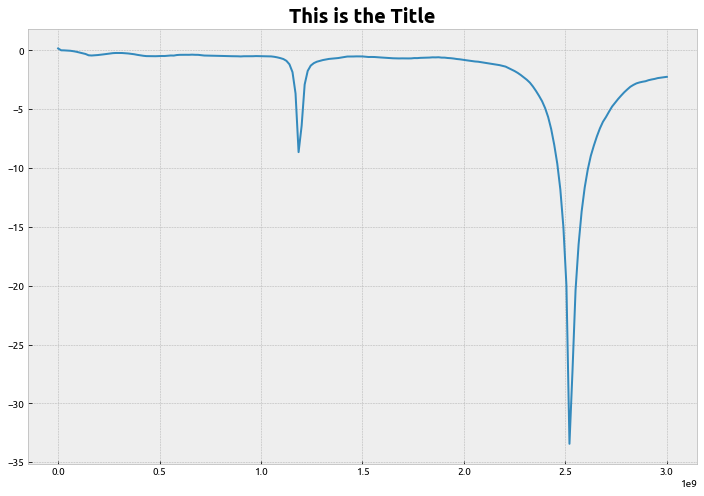

In [36]:
def set_plot_style():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Ubuntu'
    plt.rcParams['font.monospace'] = 'Ubuntu Mono'
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 14
    plt.rcParams['figure.titlesize'] = 20
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['axes.titleweight'] = 'bold'


set_plot_style()

plt.title('This is the Title')

plt.plot(freq_array,data_array)



## Raw Data

Remember that what we grabbed from the VNA and plotted above was the *formatted* data. You're pulling the data in whatever format is displayed on the screen. If you were looking at phase on the VNA screen, you would be getting results in degrees. If you were looking at VSWR, you would be getting VSWR:1.

Its probably more useful for use to request the *raw* data, magnitude and phase, so that we can create our own S-parameter files from it for use later and in other tools. If we then want to format it as Log-Mag or VSWR or smith or whatever, we can just do with with some math inside the notebook. 

Below, we'll go back to our VXI-11 `ask` command to request the unformatted data from the VNA. Similarly, we'll also request the frequency data again. This time, we'll store them in variables starting with `s_` to remind us its the raw data.



In [19]:
# Request the raw S parameter data from the VNA (not formatted)
s_data = E5062A.ask(":CALC1:DATA:SDAT?")

# Request the frequency data from the VNA
s_freq = E5062A.ask(":SENS1:FREQ:DATA?")


## Conversions

We'll convert the text string into array of numbers as before. But now, what we now have are complex values for S11 so we don't need to throw away every other element of the data array with the slice like before. We'll get to the complexity of that in a moment. 


In [21]:
# Convert the text string into array of numbes as before. Note that we now have complex values for S11
# so we don't need to throw away every other element of the data array with the slice like before
s_data_array = np.asarray(s_data.split(',')).astype(float)
s_freq_array = np.asarray(s_freq.split(',')).astype(float)



## Lets see what we got

Ok, lets look at the format of the data. It doesn't seem to give the j for the complex component. The data is pair (you can check the Keysight programming manual to verify). The first number is the real component of the first point. The second number is the imaginary component. So on... 

We need to convert these to proper complex number pairs to do math on them.

In [22]:
# Print out the format after basic conversion to array of numbers. 
print(s_data_array, '\n')


[ 1.01837876  0.00545481  0.93812202 -0.3467045   0.75846993 -0.64904236
  0.49196472 -0.8678247   0.16351276 -0.98279061 -0.18745424 -0.97344271
 -0.50938868 -0.84397624 -0.7643418  -0.61139354 -0.92080652 -0.30959681
 -0.9644394   0.02001797 -0.89045969  0.33806246 -0.73771682  0.60044817
 -0.51093175  0.80345382 -0.23368987  0.92511205  0.05993138  0.95535453
  0.34557678  0.89752751  0.5977847   0.75704494  0.79807308  0.55017617
  0.92596457  0.29796378  0.97383738  0.022033    0.94107535 -0.25445228
  0.8320661  -0.50977467  0.65427413 -0.72068009  0.42855676 -0.87129374
  0.16924664 -0.95112291 -0.09801113 -0.95699331 -0.3544357  -0.88948166
 -0.5804186  -0.75641997 -0.75977301 -0.56781752 -0.88223862 -0.33935532
 -0.94064446 -0.08733482 -0.9297741   0.16781797 -0.84936445  0.41181351
 -0.71394644  0.61988361 -0.51966695  0.78949278 -0.29140488  0.90009613
 -0.04628343  0.94658766  0.20280726  0.92866856  0.43351486  0.84692666
  0.64077265  0.70771612  0.80164905  0.51958763  0

## Sanity Check

Want a sanity check? The VNA is set up for 201 measurment points. We would expect 402 numbers if we're getting a complex pair for each. Lets look at a little trick to see how big an array of numbers is.



In [23]:
print("The number of numbers is ", s_data_array.size, '\n')

The number of numbers is  402 



## Remember the slices? 

Seem like they might be the key here? We can use one slice to get every other element starting with the first (index 0) and one to get every other element starting with the second (index 1).

You can check the printed output against the full table above.



In [24]:
# Grab every other element starting with the very first one (index 0). Happens to be the real elements
s_real = s_data_array[0::2]
# Grab every other element starting with the very second one (index 1). These are the imaginary components.
s_img = s_data_array[1::2]

print("Real:", '\n')
print(s_real, '\n')

print("Imaginary:", '\n')
print(s_img, '\n')


Real: 

[ 1.01837876  0.93812202  0.75846993  0.49196472  0.16351276 -0.18745424
 -0.50938868 -0.7643418  -0.92080652 -0.9644394  -0.89045969 -0.73771682
 -0.51093175 -0.23368987  0.05993138  0.34557678  0.5977847   0.79807308
  0.92596457  0.97383738  0.94107535  0.8320661   0.65427413  0.42855676
  0.16924664 -0.09801113 -0.3544357  -0.5804186  -0.75977301 -0.88223862
 -0.94064446 -0.9297741  -0.84936445 -0.71394644 -0.51966695 -0.29140488
 -0.04628343  0.20280726  0.43351486  0.64077265  0.80164905  0.90882469
  0.95540153  0.93883913  0.86330555  0.72901016  0.54847844  0.33113175
  0.09775158 -0.13807898 -0.37654159 -0.58462409 -0.75531621 -0.87189008
 -0.9363177  -0.93970491 -0.88193645 -0.76958824 -0.60000415 -0.39442966
 -0.1646165   0.07880107  0.31777821  0.52967136  0.71484029  0.85048248
  0.92783399  0.94296041  0.89332391  0.77684484  0.6075427   0.39051008
  0.13964311 -0.12848398 -0.39121431 -0.62764516 -0.79404483 -0.80923739
 -0.49958885  0.18621201  0.15895156 -0.449

## Complex Numbers

We now have two arrays. One with all the real parts of the raw data for each frequency point and one with all the imaginary components of the frequency points. We need to turn this into an array of complex numbers. Python uses the *j* convention for the imarginary components. Because we have the Numpy matrix math library, we can operate on the arrays just like matrix math. Addition is element-wise and multiplication by a scalar, even an imaginary one, operates on all elements. You can make the complex number pairs by adding the first array to the second array multiplied by j.


In [27]:
# Create complex number from real array and imaginary array
complex_array = s_real + 1j * s_img

print(complex_array, '\n')
print("The number of numbers is ", complex_array.size, '\n')

[ 1.01837876+0.00545481j  0.93812202-0.3467045j   0.75846993-0.64904236j
  0.49196472-0.8678247j   0.16351276-0.98279061j -0.18745424-0.97344271j
 -0.50938868-0.84397624j -0.7643418 -0.61139354j -0.92080652-0.30959681j
 -0.9644394 +0.02001797j -0.89045969+0.33806246j -0.73771682+0.60044817j
 -0.51093175+0.80345382j -0.23368987+0.92511205j  0.05993138+0.95535453j
  0.34557678+0.89752751j  0.5977847 +0.75704494j  0.79807308+0.55017617j
  0.92596457+0.29796378j  0.97383738+0.022033j    0.94107535-0.25445228j
  0.8320661 -0.50977467j  0.65427413-0.72068009j  0.42855676-0.87129374j
  0.16924664-0.95112291j -0.09801113-0.95699331j -0.3544357 -0.88948166j
 -0.5804186 -0.75641997j -0.75977301-0.56781752j -0.88223862-0.33935532j
 -0.94064446-0.08733482j -0.9297741 +0.16781797j -0.84936445+0.41181351j
 -0.71394644+0.61988361j -0.51966695+0.78949278j -0.29140488+0.90009613j
 -0.04628343+0.94658766j  0.20280726+0.92866856j  0.43351486+0.84692666j
  0.64077265+0.70771612j  0.80164905+0.51958763j  0

## Lets see if that worked.

We're going to use another library, the Scikit-RF library, to print so some S-parameter manipulations for us. I am not going to go into the details of this powerful library in this demo. We'll talk about that more another time. For the purposes of this sanity check, you just need to trust that it works the way I say it does.

Lets create an 1 port network using our RF library.

### Note 

The network creation function expects frequencies in GHz and our frequency array is in Hz so we need to divide by 1 GHz.


In [29]:
# Import the library
import skrf as rf

ntwk = rf.Network(frequency=freq_array/1e9, s= complex_array, z0=50, name='2.4 GHz Antenna')

# Print out description of the network object
print(ntwk)

1-Port Network: '2.4 GHz Antenna',  0.0003-3.0 GHz, 201 pts, z0=[50.+0.j]


## Plotting with the Scikit RF Toolkit Library

If we did all our conversions correctly, an s11 plot of the network object should look like the formatted data we pulled above. Scroll up and check!


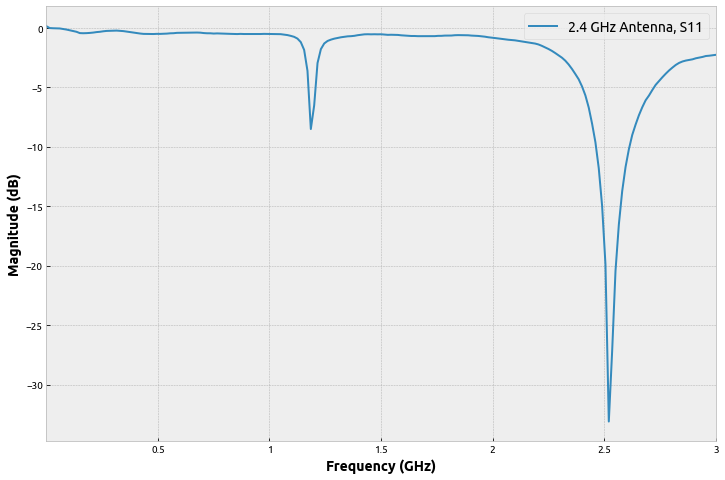

In [30]:
ntwk.s11.plot_s_db()

## Frequency Slicing

We can also now do stuff like look at only portions of frequency, change format, etc. This library allows for a special kind of slicing by frequency. Its smart enough to understand units, albeit lowercase. Try it with some different units.


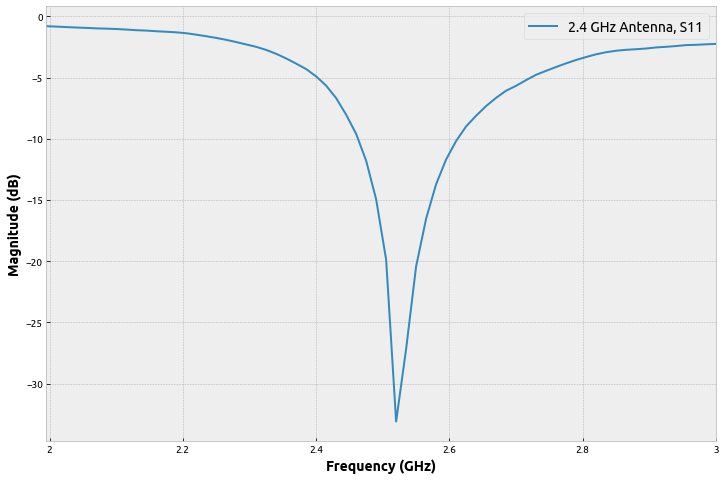

In [31]:
ntwk.s11['2-3ghz'].plot_s_db()

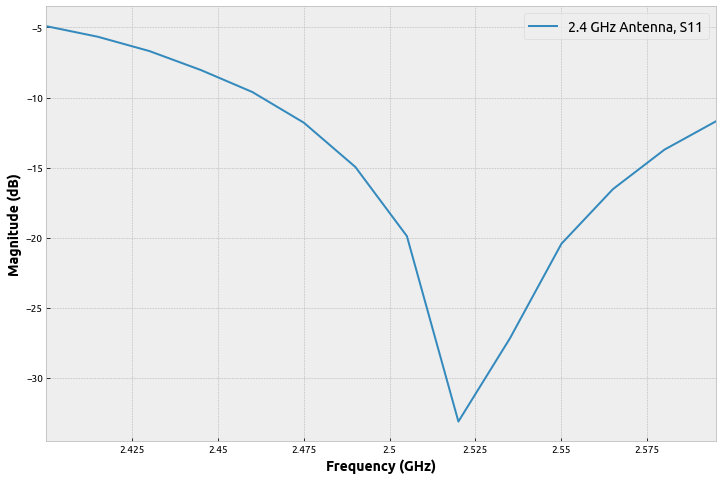

In [32]:
ntwk.s11['2400-2600mhz'].plot_s_db()

## MOAR!!!

We can plot other things like phase, VSWR, smith chart format, etc. See some examples below.

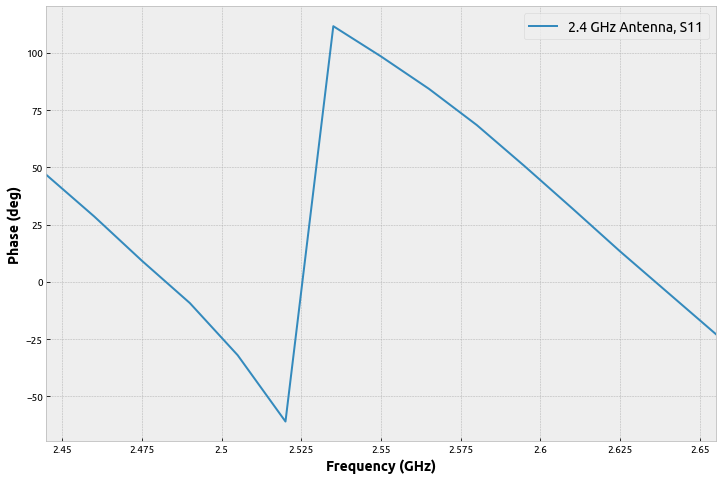

In [33]:
ntwk.s11['2.45-2.65ghz'].plot_s_deg()

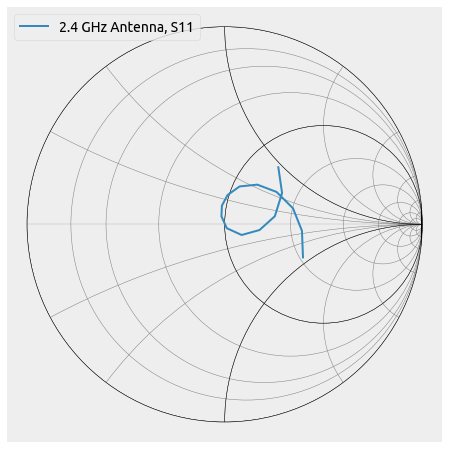

In [34]:
ntwk.s11['2.45-2.65ghz'].plot_s_smith()

## Putting it all together 

Alright. So we have seen how all this works.

*"But that took forever"* you might say.

Thats only becuase showed every step to help you understand how this works step by step. We can actually lump this all together into a very short setup block that you can just copy into your notebook and use. You don't need to understand how functions work right now. Just trust me.

I'll break this up into two blocks. A run-once setup block and then a single function you can use to to grab the trace from the VNA screen and put a title and a timestamp on it.

In [37]:
# *** Setup ***

# Import the VXI Library
import vxi11

# Other Imports
import matplotlib.pyplot as plt 
import numpy as np 
import datetime as dt

# Define the instrument we'll be connecting to. If we talk to multiple things, we can define multiple instruments
instr =  vxi11.Instrument("10.1.10.177", "hpib9,17")

# Send the ID query to verify communications. Print result. This is the hardest part.
print(instr.ask("*IDN?"))

def set_plot_style():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Ubuntu'
    plt.rcParams['font.monospace'] = 'Ubuntu Mono'
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 14
    plt.rcParams['figure.titlesize'] = 20
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['axes.titleweight'] = 'bold'

set_plot_style()

def get_trace(data_label):
    data = instr.ask(":CALC1:DATA:FDAT?")
    freq = instr.ask(":SENS1:FREQ:DATA?")
    freq_array = np.asarray(freq.split(',')).astype(float)
    data_array = np.asarray(data.split(',')).astype(float)[0::2]
    plt.plot(freq_array,data_array,label=data_label+' '+str(dt.datetime.now().strftime("%Y-%m-%d, %H:%M")))
    plt.legend()


Agilent Technologies,E5062A,MY44100797,A.01.00


## Using Our New Shortcut

We've created a function that does all the repetitive steps for us. Now, when you're collecting data, all you need is this one command. We can *pass* it a title by putting it inside the function brackets.


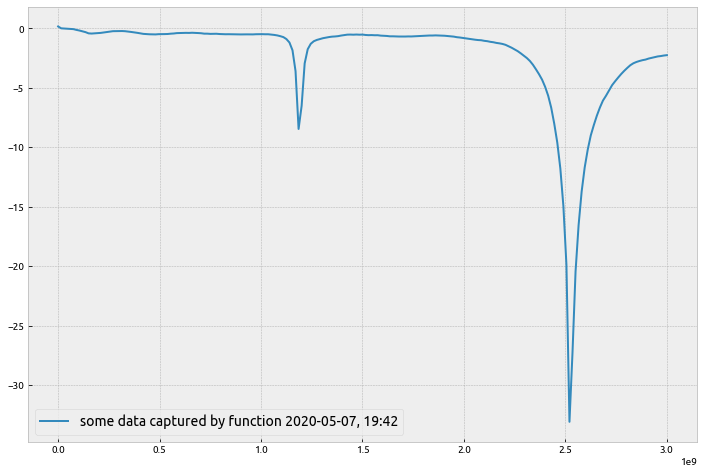

In [38]:
get_trace('some data captured by function')

## Fresh Data

Every time we run this function, we get a fresh plot. We're not just replotting the same data. If you touch the antenna and rerun it, you get a fresh plot with a fresh timestamp showing the loading effect of your hand.

### NOTE:
The plots autoscale by default so I am manually setting the limit for the detuned plot so the scale does not change. There are other ways of more formally doing this.

(-35.0, 2.5)

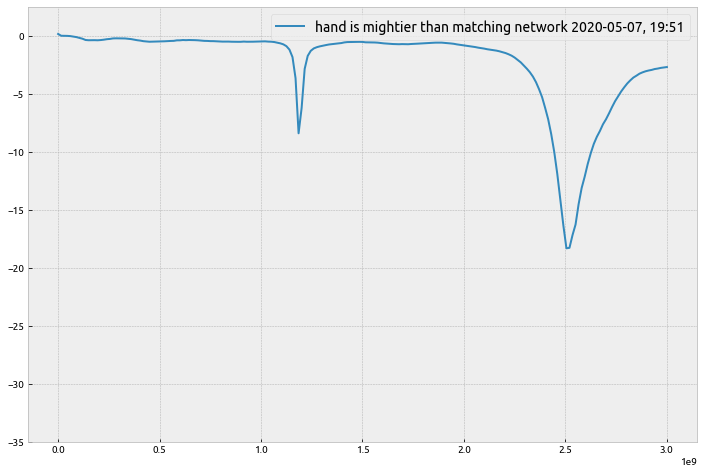

In [43]:
get_trace('hand is mightier than matching network')

# Force to same scale as other plot
plt.ylim(-35, 2.5)